<a href="https://colab.research.google.com/github/tsanoop887-hash/metro-lane/blob/main/metro_lane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
uploaded=files.upload()
IMAGE_PATH=list(uploaded.keys())[0]
print("loaded image:",IMAGE_PATH)

Saving 76820693-df769c00-6831-11ea-980a-a2cbc56ba536.png to 76820693-df769c00-6831-11ea-980a-a2cbc56ba536.png
loaded image: 76820693-df769c00-6831-11ea-980a-a2cbc56ba536.png


Text(0.5, 1.0, 'Banglore Metro Mao Input Image')

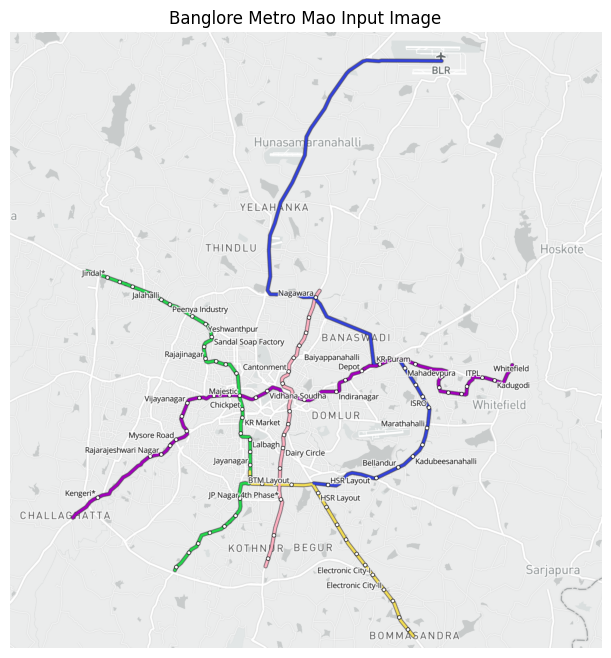

In [4]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread(IMAGE_PATH)
img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.axis("off")
plt.title("Banglore Metro Mao Input Image")


In [5]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray=cv2.medianBlur(gray,5)

circles=cv2.HoughCircles(
    gray,cv2.HOUGH_GRADIENT,dp=1.2,minDist=30,
    param1=80,param2=30,
    minRadius=5,maxRadius=30

)

stations=[]
if circles is not None:
  circles=circles[0]
  for(x,y,r) in circles:
    stations.append((int(x),int(y)))
print("Stations detected :", len(stations))

Stations detected : 12


Text(0.5, 1.0, 'Detected Stations (Blue Dots)')

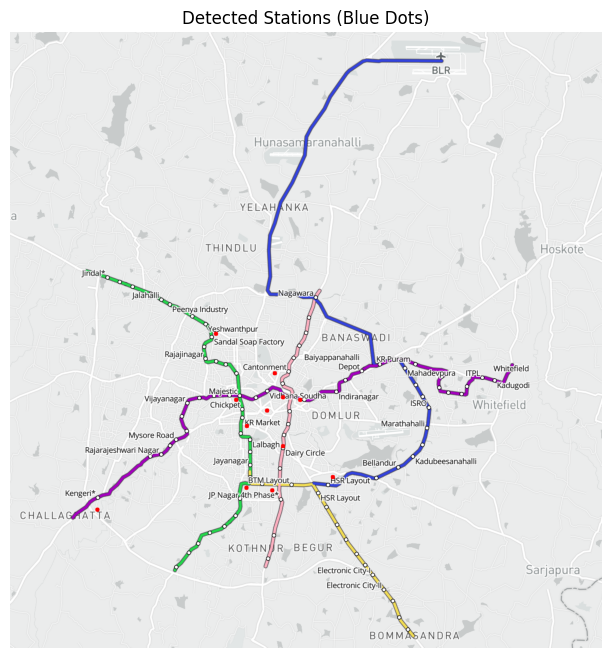

In [6]:
vis = img_rgb.copy()
for (x,y) in stations:
    cv2.circle(vis, (x,y), 5, (255,0,0), -1)

plt.figure(figsize=(8,8))
plt.imshow(vis)
plt.axis("off")
plt.title("Detected Stations (Blue Dots)")

In [7]:
import networkx as nx
import math

G=nx.Graph()

for i,(x,y) in enumerate(stations):
  G.add_node(i,pos=(x,y))

  for i in range(len(stations)):
    for j in range(i+1,len(stations)):
      x1,y1=stations[i]
      x2,y2=stations[j]
      dist=math.dist((x1,y1),(x2,y2))

      if dist<150:
        G.add_edge(i,j,weight=dist)
print("Graph Nodes :",G.number_of_nodes())
print("Graph Edges: ",G.number_of_edges())


Graph Nodes : 12
Graph Edges:  25


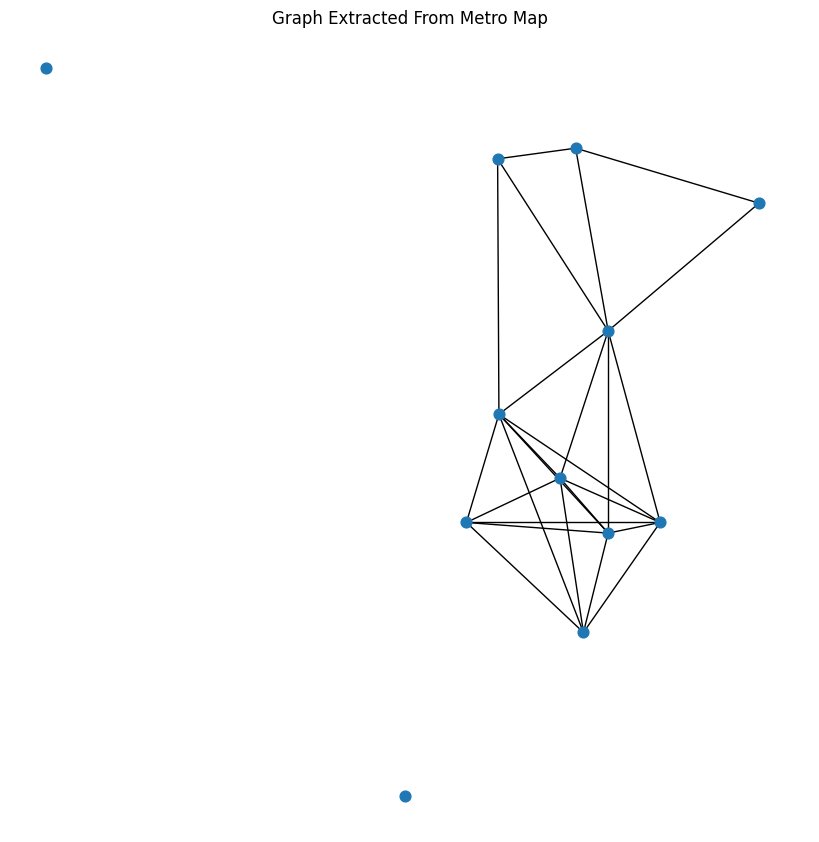

In [8]:
pos = nx.get_node_attributes(G, "pos")

plt.figure(figsize=(8,8))
nx.draw(G, pos, node_size=60, font_size=8)
plt.title("Graph Extracted From Metro Map")
plt.show()


In [11]:
import torch
from torch_geometric.utils import from_networkx

data = from_networkx(G)

coords = torch.tensor([[x, y] for (x, y) in stations], dtype=torch.float)
data.x = coords


In [12]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(2, 32)
        self.conv2 = GCNConv(32, 32)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

gnn = GCN()
optimizer = torch.optim.Adam(gnn.parameters(), lr=0.01)

In [13]:
for epoch in range(200):
    optimizer.zero_grad()
    out = gnn(data.x, data.edge_index)
    loss = out.mean()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())


Epoch: 0 Loss: 49.64066696166992
Epoch: 20 Loss: -1643.5084228515625
Epoch: 40 Loss: -6558.68505859375
Epoch: 60 Loss: -16112.7822265625
Epoch: 80 Loss: -31089.845703125
Epoch: 100 Loss: -51871.15625
Epoch: 120 Loss: -78626.2890625
Epoch: 140 Loss: -111419.2578125
Epoch: 160 Loss: -150260.375
Epoch: 180 Loss: -195131.734375


In [14]:
node_embeddings = gnn(data.x, data.edge_index).detach()
node_embeddings.shape


torch.Size([12, 32])

In [15]:
import random
import torch.nn as nn

class MetroEnv:
    def __init__(self, graph, goal):
        self.G = graph
        self.goal = goal

    def reset(self):
        self.state = random.choice(list(self.G.nodes()))
        return node_embeddings[self.state]

    def step(self, action):
        neighbors = list(self.G[self.state])
        if len(neighbors)==0:
            return node_embeddings[self.state], -10, True

        action = min(action, len(neighbors)-1)
        next_state = neighbors[action]

        reward = -1
        if next_state == self.goal:
            reward += 50

        done = (next_state == self.goal)

        self.state = next_state
        return node_embeddings[self.state], reward, done

In [16]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.nn(x)

dqn = DQN(32, 6)
opt = torch.optim.Adam(dqn.parameters(), lr=0.001)

In [18]:
episodes = 120

env = MetroEnv(G, goal=0) # Initialize the environment with the graph G and a goal node (e.g., node 0)

for ep in range(episodes):
    state = env.reset()
    done = False

    while not done:
        qvals = dqn(state)
        action = torch.argmax(qvals).item()

        next_state, reward, done = env.step(action)

        q_target = reward + 0.9 * torch.max(dqn(next_state))
        q_pred = qvals[action]

        loss = (q_pred - q_target)**2
        opt.zero_grad()
        loss.backward()
        opt.step()

    if ep % 10 == 0:
        print(f"Episode {ep}: Loss = {loss.item()}")

Episode 0: Loss = 54478240.0
Episode 10: Loss = 2399.822998046875
Episode 20: Loss = 2399.231201171875
Episode 30: Loss = 100.45454406738281
Episode 40: Loss = 2398.364501953125
Episode 50: Loss = 2397.9453125
Episode 60: Loss = 2397.627685546875
Episode 70: Loss = 2397.193603515625
Episode 80: Loss = 2396.849609375
Episode 90: Loss = 2396.496337890625
Episode 100: Loss = 2396.208251953125
Episode 110: Loss = 2395.845947265625


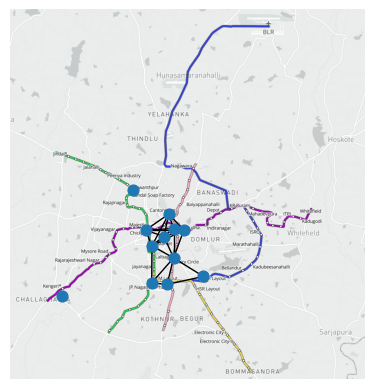

In [20]:
plt.imshow(vis)
nx.draw(G, pos, node_size=60)


In [23]:
def run_agent(start, goal):
    state = start
    route = [state]

    done = False
    while not done:
        s_embed = node_embeddings[state]
        qvals = dqn(s_embed)
        action = torch.argmax(qvals).item()

        neighbors = list(G[state])

        # Ensure the action is within the bounds of available neighbors
        if not neighbors:
            # Handle cases where a node has no neighbors (should ideally not happen in a connected graph for valid paths)
            break
        action = min(action, len(neighbors) - 1)

        next_state = neighbors[action]

        route.append(next_state)
        done = (next_state == goal)
        state = next_state

    return route

In [24]:
print(run_agent(start=10, goal=0))


[10]


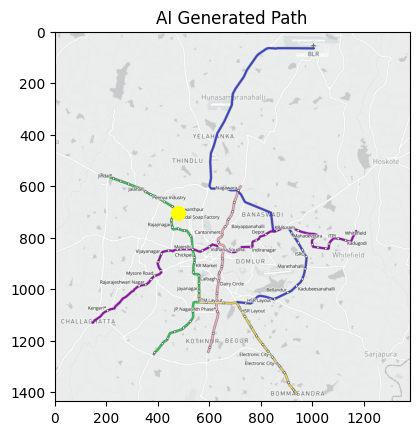

In [25]:
path = run_agent(10, 0)

path_pos = [stations[i] for i in path]

x = [p[0] for p in path_pos]
y = [p[1] for p in path_pos]

plt.imshow(img_rgb)
plt.plot(x, y, color='red', linewidth=3)
plt.scatter(x, y, color='yellow', s=100)
plt.title("AI Generated Path")
plt.show()


In [26]:
station_names = {
    0: "Kengeri",
    1: "Nayandahalli",
    2: "Mysore Road",
    3: "Vijayanagar",
    4: "Attiguppe",
    5: "Hosahalli",
    6: "Vijayanagar",
    7: "Majestic",
    8: "Chikkapete",
    9: "KR Market",
    10: "Lalbagh",
    11: "Jayanagar",
    12: "JP Nagar",
    13: "Banashankari",
    14: "Rashtriya Vidyalaya Road",
    15: "Jayanagar",
    16: "East-West Corridor",
    17: "Indiranagar",
    18: "KR Puram",
    19: "Whitefield",
    20: "ITPL",
    # Add more depending on detected stations...
}


In [27]:
station_names = {i: f"Station_{i}" for i in range(len(stations))}


In [28]:
def run_agent(start, goal):
    state = start
    route = [state]
    total_reward = 0
    visited = set()

    for _ in range(50):  # avoid infinite loops
        s_embed = node_embeddings[state]
        qvals = dqn(s_embed)
        action = torch.argmax(qvals).item()

        neighbors = list(G[state])
        if len(neighbors) == 0:
            break

        action = min(action, len(neighbors)-1)
        next_state = neighbors[action]

        # reward
        reward = -1
        if next_state == goal:
            reward += 50

        total_reward += reward
        route.append(next_state)

        if next_state == goal:
            break

        state = next_state

    return route, total_reward


In [30]:
start_station = 0 # Changed from 15 to a valid index
goal_station  = 7  # Majestic (example)

route, reward = run_agent(start_station, goal_station)

print("AI Selected Route:")
for r in route:
    print(" →", station_names.get(r, r))

print("\nTotal Reward:", reward)

AI Selected Route:
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0
 → Station_3
 → Station_0

Total Reward: -50


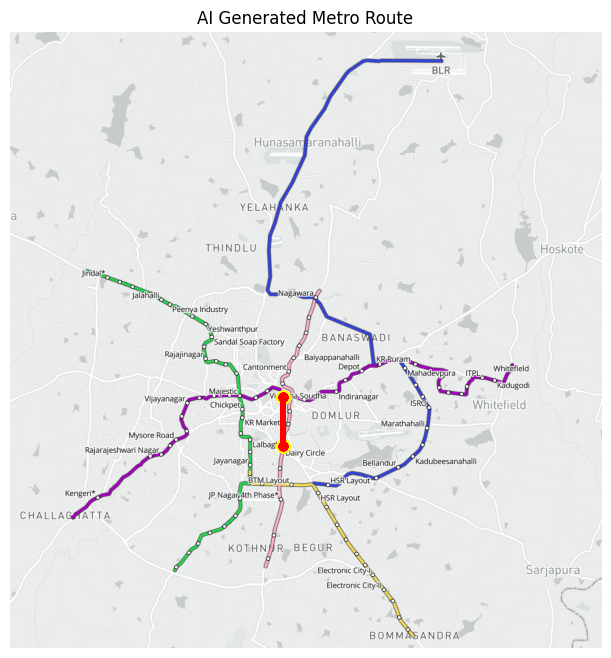

In [31]:
path_points = [stations[i] for i in route]

# x and y coordinates
x = [p[0] for p in path_points]
y = [p[1] for p in path_points]

plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.plot(x, y, color='red', linewidth=3, marker='o')
plt.scatter(x, y, color='yellow', s=80)
plt.title("AI Generated Metro Route")
plt.axis("off")
plt.show()
